In [1]:
import sympy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import dataset
import dataset_feynman1d
import dataset_feynman2d
import dataset_physics
import dataset_misc1d
import dataset_misc2d
import dataset_misc3d
from backprop import library, project, diversify
from gp import gp
from gp import creator as gp_creator
from gp import evaluator as gp_evaluator, selector as gp_selector
from gp import crossover as gp_crossover, mutator as gp_mutator
from gp import corrector as gp_corrector
from symbols import syntax_tree
import randstate

In [2]:
SAMPLE_SIZE = 200
TRAIN_SIZE  = 0.7
NOISE       = 0.#05
MESH_SIZE   = 100

POPSIZE          = 100
MAX_STREE_DEPTH  = 5
MAX_STREE_LENGTH = 20
GENERATIONS      = 50
GROUP_SIZE       = 5  # tournament selector.
MUTATION_RATE    = 0.15
ELITISM          = 1

LIBSIZE       = 2000
LIB_MAXDEPTH  = 3
LIB_MAXLENGTH = 10

RANDSTATE = None#124

In [3]:
randstate.setstate(RANDSTATE)

#S = dataset_misc1d.MagmanDatasetScaled()
#S = dataset_misc2d.Resistance2()
#S = dataset_misc1d.ABSDataset()
S = dataset_misc3d.Gravity()
#S = dataset_feynman2d.FeynmanICh6Eq20()
#S = dataset_feynman1d.FeynmanIICh27Eq16()
#S = dataset_physics.AircraftLift()

S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')

S.split(train_size=TRAIN_SIZE)
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [4]:
np.seterr(all='ignore')

syntax_tree.SyntaxTreeInfo.set_problem(S_train)

y_iqr = S_train.get_y_iqr()
solutionCreator = gp_creator.PTC2RandomSolutionCreator(nvars=S.nvars, y_iqr=y_iqr)

multiMutator = gp_mutator.MultiMutator(
      gp_mutator.SubtreeReplacerMutator(MAX_STREE_DEPTH, MAX_STREE_LENGTH, solutionCreator),
      gp_mutator.FunctionSymbolMutator(),
      gp_mutator.NumericParameterMutator(all=True, y_iqr=y_iqr),
      #gp.NumericParameterMutator(all=False, y_iqr=y_iqr)
      )

X_mesh         = S_train.spsampler.meshspace(S_train.xl, S_train.xu, MESH_SIZE)
know_evaluator = gp_evaluator.KnowledgeEvaluator(S.knowledge, X_mesh)
r2_evaluator   = gp_evaluator.R2Evaluator(S_train)
evaluator      = gp_evaluator.LayeredEvaluator(know_evaluator, r2_evaluator)

selector  = gp_selector.TournamentSelector(GROUP_SIZE)
crossover = gp_crossover.SubTreeCrossover(MAX_STREE_DEPTH, MAX_STREE_LENGTH)
corrector = gp_corrector.Corrector(S_train, S.knowledge, MAX_STREE_DEPTH, MAX_STREE_LENGTH, X_mesh, LIBSIZE, LIB_MAXDEPTH, LIB_MAXLENGTH, solutionCreator)

symb_regressor = \
         gp.GP(POPSIZE, GENERATIONS, MAX_STREE_DEPTH, MAX_STREE_LENGTH, S_train, S_test,
               creator=solutionCreator,
               evaluator=evaluator,
               selector=selector,
               crossover=crossover,
               mutator=multiMutator,
               corrector=corrector,
               mutrate=MUTATION_RATE,
               elitism=ELITISM,
               knowledge=S.knowledge)

import profiling

with tqdm(total=symb_regressor.ngen-1) as pbar:
      def on_newgen(genidx, status):
            pbar.update(1)
            pbar.set_description(status)
      best_stree, best_eval = symb_regressor.evolve(newgen_callback=on_newgen)

profiling.print_stats()

print("\n--- Best syntax tree ---")
print(best_stree)
print(best_eval)
print(f"Max depth: {best_stree.get_max_depth()}")
print(f"Length: {best_stree.get_nnodes()}")
#if corrector is not None: print(f"Lib radius faults: {corrector.lib.get_radius_faults()}")

  0%|          | 0/49 [00:00<?, ?it/s]

         1639646 function calls (1365396 primitive calls) in 4.322 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4900    0.117    0.000    4.317    0.001 corrector.py:24(correct)
     4900    0.064    0.000    2.112    0.000 corrector.py:72(backprop_know)
     4887    0.075    0.000    1.209    0.000 library.py:500(cquery)
     4605    0.034    0.000    0.904    0.000 library.py:537(__local_cquery)
95354/13121    0.202    0.000    0.767    0.000 binop.py:28(__getitem__)
     4887    0.009    0.000    0.756    0.000 library.py:77(query)
     4887    0.476    0.000    0.746    0.000 _kdtree.py:363(query)
29032/9774    0.027    0.000    0.599    0.000 syntax_tree.py:139(pull_know_deriv)
22438/8592    0.477    0.000    0.595    0.000 binop.py:247(pull_know_deriv)
14575/4900    0.014    0.000    0.445    0.000 syntax_tree.py:134(pull_know)
11256/4309    0.360    0.000    0.443    0.000 binop.py:184(pull_know)
    44893 

In [5]:
profiling.print_stats()

         1639646 function calls (1365396 primitive calls) in 4.322 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4900    0.117    0.000    4.317    0.001 corrector.py:24(correct)
     4900    0.064    0.000    2.112    0.000 corrector.py:72(backprop_know)
     4887    0.075    0.000    1.209    0.000 library.py:500(cquery)
     4605    0.034    0.000    0.904    0.000 library.py:537(__local_cquery)
95354/13121    0.202    0.000    0.767    0.000 binop.py:28(__getitem__)
     4887    0.009    0.000    0.756    0.000 library.py:77(query)
     4887    0.476    0.000    0.746    0.000 _kdtree.py:363(query)
29032/9774    0.027    0.000    0.599    0.000 syntax_tree.py:139(pull_know_deriv)
22438/8592    0.477    0.000    0.595    0.000 binop.py:247(pull_know_deriv)
14575/4900    0.014    0.000    0.445    0.000 syntax_tree.py:134(pull_know)
11256/4309    0.360    0.000    0.443    0.000 binop.py:184(pull_know)
    44893 

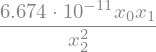

In [6]:
sympy.init_printing()
sympy.simplify(sympy.factor(best_stree.to_sympy()))

In [7]:
best_stree.clear_output()
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)
S.evaluate_extra(best_stree)

{'mse': 1.5071103684599097e-32, 'rmse': 1.2276442352977958e-16, 'r2': 1.0}

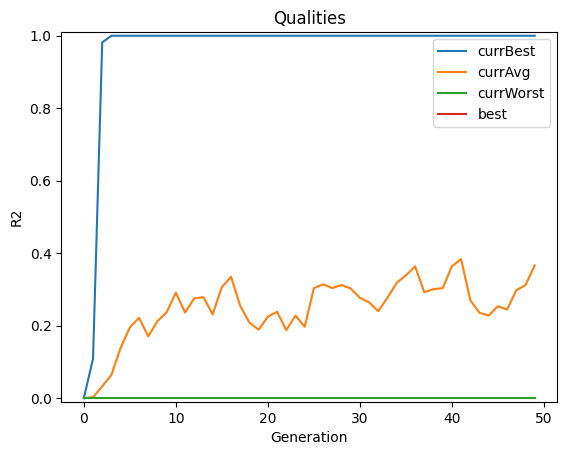

In [8]:
for quality, qseries in symb_regressor.stats.qualities.items():
    plt.plot(qseries, label=quality)

plt.legend()
plt.ylim((-0.01, 1.01))
plt.xlabel('Generation')
plt.ylabel('R2')
plt.title('Qualities')
plt.show()

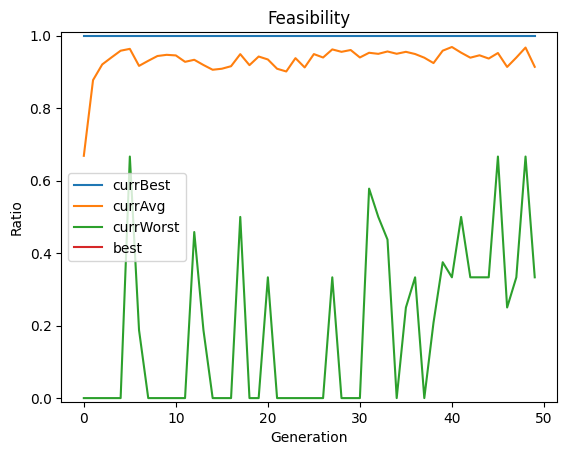

In [9]:
for quality, qseries in symb_regressor.stats.fea_ratio.items():
    plt.plot(qseries, label=quality)

plt.legend()
plt.ylim((-0.01, 1.01))
plt.xlabel('Generation')
plt.ylabel('Ratio')
plt.title('Feasibility')
plt.show()

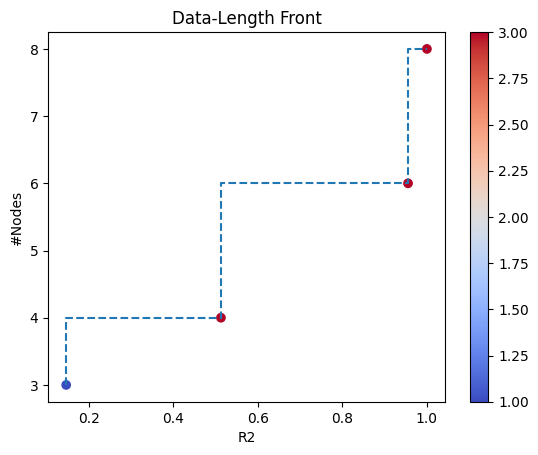

,Score,Model,Front,fpn,R2,Length,Symbset,Symbdist,Crowdist
0,0,(0.00 / x2),0,0.124966,0.147019,3,(/),1,inf
1,1,((x1 / square(x2)) / (14983518130.06 / x0)),0,0.600000,1.000000,8,"(/, square)",3,inf
2,2,(0.00 / square(x2)),0,0.410355,0.512944,4,"(/, square)",3,1.547636
3,3,(0.00 / (square(x2) / x1)),0,0.668734,0.955334,6,"(/, square)",3,1.371005
4,0,(x0 / 6007783614.70),1,0.009887,0.011631,3,(),1,inf
5,1,((x1 / x2) / (14983518130.06 / (x0 / x2))),1,0.550000,1.000000,9,(/),3,inf
6,2,(x2 / (cube(x2) / 0.00)),1,0.359061,0.512944,6,"(/, cube)",1,1.059246
7,3,(-0.00 / (x2 / -261926852184.57)),1,0.178399,0.237865,5,(/),3,1.007212
8,4,(0.00 / (x2 / (x1 / x2))),1,0.620967,0.955334,7,(/),3,0.783194
9,5,(11.97 / (14983518130.06 / (x1 / square(x2)))),1,0.574543,0.957572,8,"(/, square)",1,0.378525


In [10]:
pd_data = []
front_tracker = symb_regressor.fea_front_tracker.front_tracker_a

for frontidx in range(front_tracker.nfronts):

    front = front_tracker.get_front(frontidx)
    symbset, symbdist = front_tracker.compute_symbdist(frontidx)
    crowdist = front_tracker.compute_crowdist(frontidx)
    
    for idx, (stree, data, length) in enumerate(front):
        pd_data.append(
            [idx, stree, frontidx, data*(1.-min(1.,length/20)), data, length, symbset[id(stree)], symbdist[id(stree)], crowdist[id(stree)]]
        )

front_tracker.plot(0)
pd.DataFrame(pd_data, columns=['Score', 'Model', 'Front', 'fpn', 'R2', 'Length', 'Symbset', 'Symbdist', 'Crowdist']).head(n=60)
#print(front_tracker.symbfreq.freq)
#print(symb_regressor.fea_front_tracker.front_tracker_b.symbfreq.freq)